<a href="https://colab.research.google.com/github/victor-roris/mediumseries/blob/master/NLP/NLPModel_MultiLabel_Transformers_KTRAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A Simplied Interface to Text Classification With Hugging Face Transformers in TensorFlow Using [ktrain](https://github.com/amaiya/ktrain)

*ktrain* requires TensorFlow 2.

The ktrain library is a lightweight wrapper for tf.keras in TensorFlow 2. It includes a simplified interface to *Hugging Face transformers* for **text classification**. In this article, we will show you how you can build, train, and deploy a text classification model with Hugging Face transformers in only a few lines of code.

source: https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed



In [1]:
# TensorFlow 2
!pip install -q tensorflow_gpu>=2.0

ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.2 which is incompatible.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


We then need to install *ktrain* library using pip.

In [3]:
!pip install -q ktrain

     |████████████████████████████████| 102kB 3.2MB/s 
     |████████████████████████████████| 6.7MB 11.1MB/s 
     |████████████████████████████████| 1.0MB 46.2MB/s 
     |████████████████████████████████| 245kB 53.1MB/s 
     |████████████████████████████████| 1.8MB 53.9MB/s 
     |████████████████████████████████| 450kB 49.7MB/s 
     |████████████████████████████████| 870kB 52.0MB/s 
     |████████████████████████████████| 1.0MB 51.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


### Load a Dataset Into Arrays

In [4]:
categories = ['alt.atheism', 'soc.religion.christian',
             'comp.graphics', 'sci.med']
             
from sklearn.datasets import fetch_20newsgroups
train_b = fetch_20newsgroups(subset='train',
   categories=categories, shuffle=True, random_state=42)
test_b = fetch_20newsgroups(subset='test',
   categories=categories, shuffle=True, random_state=42)

print('size of training set: %s' % (len(train_b['data'])))
print('size of validation set: %s' % (len(test_b['data'])))
print('classes: %s' % (train_b.target_names))

size of training set: 2257
size of validation set: 1502
classes: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


In [5]:
# Get the datasets as array 

x_train = train_b.data
y_train = train_b.target
x_test = test_b.data
y_test = test_b.target

print(f'Train examples : {len(x_train)} - {type(x_train)}')
print(f'Train examples : {len(x_test)} - {type(x_test)}')

Train examples : 2257 - <class 'list'>
Train examples : 1502 - <class 'list'>


## Preprocess Data and Create a Transformer Model


In [6]:
import ktrain
from ktrain import text

using Keras version: 2.2.4-tf


* **Selecting the model**

Next, we must select one of the pretrained models from Hugging Face, which are all listed [here](https://huggingface.co/transformers/pretrained_models.html). As of this writing, the transformers library supports the following pretrained models for TensorFlow 2:

* BERT: bert-base-uncased, bert-large-uncased, bert-base-multilingual-uncased, and others.
* DistilBERT: distilbert-base-uncased, distilbert-base-multilingual-cased, distilbert-base-german-cased, and others
* ALBERT: albert-base-v2, albert-large-v2, and others
* RoBERTa: roberta-base, roberta-large, roberta-large-mnli
* XLM: xlm-mlm-xnli15–1024, xlm-mlm-100–1280, and others
* XLNet: xlnet-base-cased, xlnet-large-cased

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

In [0]:
MODEL_NAME = 'distilbert-base-uncased'

* **Create a Transformer instance**

The Transformer class in ktrain is a simple abstraction around the Hugging Face transformers library. Let’s instantiate one by providing the model name, the sequence length (i.e., maxlen argument) and populating the classes argument with a list of target names.

In [8]:
t = text.Transformer(MODEL_NAME, maxlen=500, classes=train_b.target_names)
t.model_name

'distilbert-base-uncased'

* **Preprocess the Datasets**
We then preprocess the training and validation datasets into the format expected by the selected pretrained model 

In [9]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: en


preprocessing test...
language: en


* **Create a Model and Wrap in Learner**

Next, we define a classifier with pretrained weights and randomly initialized final layers that can be fine-tuned. The model will be wrapped in a ```ktrain Learner``` object that will allow us to easily train and inspect the model and use it to make predictions on new data.

In [36]:
model = t.get_classifier()
model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  3076      
_________________________________________________________________
dropout_59 (Dropout)         multiple                  0         
Total params: 66,956,548
Trainable params: 66,956,548
Non-trainable params: 0
_________________________________________________________________


In [11]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner

If you experience out-of-memory errors during training, you can either try lowering the batch_size above or lowering the maxlen parameter

## Estimate the Learning Rate

We will use the Learning Rate Finder in ktrain to estimate a good learning rate for our model and dataset. This step is optional.

simulating training for different learning rates... this may take a few moments...
Train for 376 steps
Epoch 1/2
376/376 [==============================] - 149s 396ms/step - loss: 1.0412 - accuracy: 0.5541
Epoch 2/2
224/376 [================>.............] - ETA: 56s - loss: 5.4616 - accuracy: 0.2517

done.


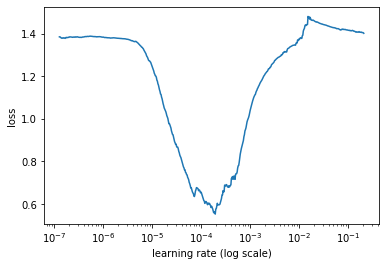

In [12]:
learner.lr_find(show_plot=True, max_epochs=2)

Here, we will select the highest learning rate associated with a falling loss. Let us choose **5e-5** as the learning rate. 

## Train the Model

For training, we will invoke the fit_onecycle method in ktrain, which employs the 1cycle policy, a learning rate schedule proposed by Leslie Smith. In general, learning rate schedules with an initial warmup period that increases the learning rate and then a decay period that gradually decreases the learning rate tend to work well for transformer-based models.

In [13]:
learner.fit_onecycle(lr=5e-5, epochs=4)



begin training using onecycle policy with max lr of 5e-05...
Train for 377 steps, validate for 251 steps
Epoch 1/4
377/377 [==============================] - 178s 471ms/step - loss: 0.6651 - accuracy: 0.7599 - val_loss: 0.2352 - val_accuracy: 0.9248
Epoch 2/4
377/377 [==============================] - 176s 468ms/step - loss: 0.1506 - accuracy: 0.9526 - val_loss: 0.2406 - val_accuracy: 0.9208
Epoch 3/4
377/377 [==============================] - 176s 468ms/step - loss: 0.0561 - accuracy: 0.9858 - val_loss: 0.1880 - val_accuracy: 0.9454
Epoch 4/4
377/377 [==============================] - 177s 468ms/step - loss: 0.0113 - accuracy: 0.9987 - val_loss: 0.1516 - val_accuracy: 0.9601


In [34]:
learner.model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  3076      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,956,548
Trainable params: 66,956,548
Non-trainable params: 0
_________________________________________________________________


## Evaluate and Inspect the Model

* **Evaluation**

In [14]:
confusion_matrix = learner.validate(class_names=t.get_classes())

                        precision    recall  f1-score   support

           alt.atheism       0.92      0.95      0.93       319
         comp.graphics       0.97      0.97      0.97       389
               sci.med       0.98      0.95      0.97       396
soc.religion.christian       0.96      0.96      0.96       398

              accuracy                           0.96      1502
             macro avg       0.96      0.96      0.96      1502
          weighted avg       0.96      0.96      0.96      1502



In [15]:
confusion_matrix

array([[302,   3,   5,   9],
       [  8, 379,   1,   1],
       [  7,   7, 378,   4],
       [ 12,   2,   1, 383]])

 *heatmap* from the Seaborn library.

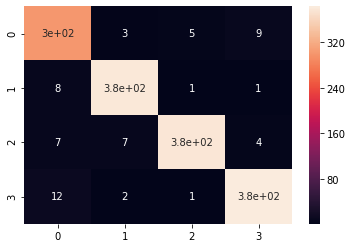

In [16]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True)

Represent in each quadrant the percentage of data

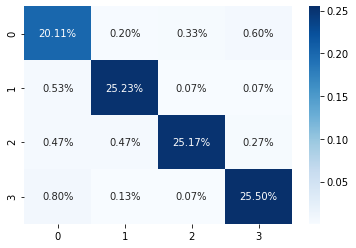

In [17]:
import numpy as np
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')

* **Inspection**

Let's examine the validation example about which we were the most wrong. We'll display the 10 most uncorrect validation examples.

In [19]:
# This function only display by console the results
learner.view_top_losses(n=10, preproc=t)

----------
id:540 | loss:6.68 | true:sci.med | pred:comp.graphics)

----------
id:810 | loss:6.32 | true:alt.atheism | pred:sci.med)

----------
id:12 | loss:6.1 | true:sci.med | pred:alt.atheism)

----------
id:288 | loss:6.05 | true:alt.atheism | pred:sci.med)

----------
id:318 | loss:6.05 | true:sci.med | pred:alt.atheism)

----------
id:371 | loss:5.91 | true:alt.atheism | pred:sci.med)

----------
id:483 | loss:5.91 | true:sci.med | pred:soc.religion.christian)

----------
id:1358 | loss:5.85 | true:alt.atheism | pred:soc.religion.christian)

----------
id:1118 | loss:5.65 | true:alt.atheism | pred:soc.religion.christian)

----------
id:1330 | loss:5.63 | true:comp.graphics | pred:sci.med)



We can see the content of the test example most wrong (540)

In [23]:
print(x_test[540])

From: werckme1@eecs.uic.edu (robert werckmeister)
Subject: ECG data needed
Organization: University of Illinois at Chicago
Lines: 3

I need some ECG data , uncompressed,  hopefully in ascii format.
Don't care what it looks like, this is for a signal processing
project.



You can see in the language that this example can be a bit confussing between clases.

## Making Predictions on New Data in Deployment

We can instantiate a Predictor object to easily make predictions on new examples.

In [25]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor

In [27]:
predictor.predict('Jesus Christ is the central figure of Christianity.')

'soc.religion.christian'

In [26]:
# predicted probability scores for each category
predictor.predict_proba('Jesus Christ is the central figure of Christianity.')

array([2.6704578e-03, 5.4197718e-04, 7.8551390e-04, 9.9600202e-01],
      dtype=float32)

In [28]:
predictor.get_classes()

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

As expected, `soc.religion.christian` is assigned the highest probability.

## Predictions explicability 

Let's invoke the `explain` method to see which words contribute most to the classification.

We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [29]:
!pip install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [30]:
predictor.explain('Jesus Christ is the central figure in Christianity.')

The words in the darkest shade of green contribute most to the classification and agree with what you would expect for this example.

## Save and Load the model

We can save and reload our predictor for later deployment.

In [0]:
predictor.save('/tmp/my_distilbert_predictor')

In [0]:
reloaded_predictor = ktrain.load_predictor('/tmp/my_distilbert_predictor')

In [33]:
reloaded_predictor.predict('My computer monitor is really blurry.')

'comp.graphics'